# Demo notebook for Computer aided detection with Faster-RCNN

### Prerequisites

* You need to install py-faster-rcnn, see the github repository for instructions: https://github.com/rbgirshick/py-faster-rcnn

* You need a GPU with at least 8GB memory, with CUDA and cuDNN

### Import modules and change Faster-RCNN configs

In [1]:
import sys
# here is my py-faster-rcnn installation
sys.path.append('/root/py-faster-rcnn/tools/')  
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
import caffe, cv2

# faster rcnn configs we need to change
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cfg.TEST.SCALES=(1737,)  # change scales
cfg.TEST.MAX_SIZE=2145  # change scales

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define functions to load model, run detection, and visualize detection

In [2]:
def load_net(ptxt, w, device=0):
    """Load model."""
    caffe.set_mode_gpu()
    caffe.set_device(device)
    cfg.GPU_ID = device
    net = caffe.Net(ptxt, w, caffe.TEST)
    return net


def detect(net, im,  NMS_THRESH = 0.1, cls_ind = 2,
           CLASSES = ('__background__','BENIGN','MALIGNANT')):
    """Detect cancer."""
    cfg.TEST.HAS_RPN = True
    scores, boxes =  im_detect(net, im)
    
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                        cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    return dets


def vis_detections(im, dets, CONF_THRESH = 0.23):
    """Draw boxes around detected cancer."""   
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False, linestyle ='dashed',
                          edgecolor=(0.95, 0.95, 0.5), linewidth=3))
    plt.axis('off')
    plt.tight_layout()

### Load the model

In [3]:
# place the model weights here
net = load_net(ptxt='vgg16_frcnn_cad_test.prototxt',
               w='vgg16_frcnn_cad.caffemodel')

### Load and analyze image

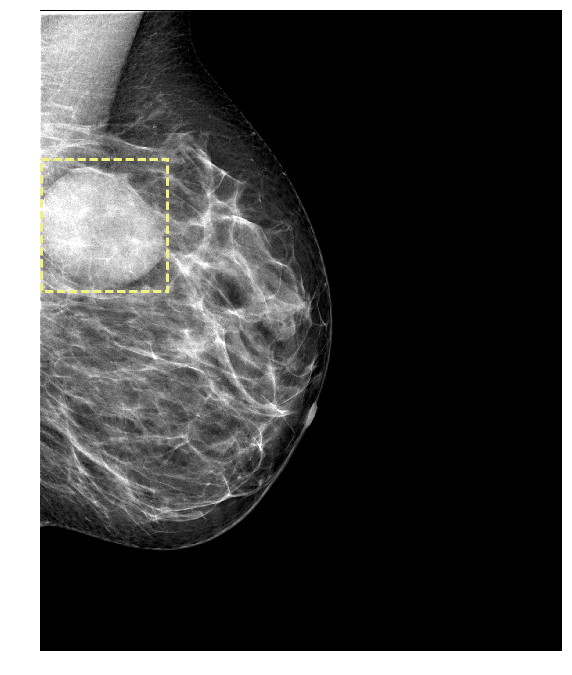

In [4]:
# load image, customize this part to load your images 
# from whatever format you use
im = cv2.imread('demo.png')  

# run detection
detections = detect(net, im)

# visualize detections
vis_detections(im, detections)

### That's it

The example image is from the INBreast dataset. Courtesy of the Breast Research Group, INESC Porto, Portugal. Thank you.